# Tutorial 5 - First optimization problem using NRV

In this tutorial, the optimization formalism used in NRV is illustrated through a detailed example. Further details on NRV optimization formalism can be found in [usersguide's optimization section](../usersguide/optimization.rst).

To reduce the computation time, this optimization will be done on a single myelinated axon. The exact same optimization problem could be applied to a nerve filled with multiple myelinated axons (see [example o01](../examples/optim/o01_nerve_optimization.ipynb))

The very first step is, as usual, to import NRV and the required packages and to generate an outputs’ repository.

In [ ]:
import sys 
sys.path.append("../../")     #data path
import nrv

import matplotlib.pyplot as plt
import numpy as np
import os

np.random.seed(444)

test_name = "Tutorial_5"
dir_res = f"./{test_name}/"
if not os.path.isdir(dir_res):
    os.mkdir(dir_res)

## First optimization: Pulse Stimulus on Single axon

The objective of the first optimization problem is to **minimize a rectangle pulse stimulus energy required by a LIFE-electrode to trigger a single myelinated fibre**.

### Cost function

To begin, we can create an empty cost function object and fill it progressively with its components.

In [ ]:
## Cost function definition
my_cost0 = nrv.cost_function()

#### Static context

The first step to implement the optimization is to define the static context. This context can be generated with the following script, the same way as in previous Tutorials (see [Tutorial 1](./1_intracellular_stimulation.ipynb)). 
In this first example the context is only composed of:

 - a myelinated axon: $10mm$ long, $10\mu m$ diameter large, with a centre located at $(y=50\mu m, z=0)$
 - a LIFE-electrode: $1mm$ long, $25\mu m$ diameter large, with a centre located at $(x=500\mu m, y=0, z=0)$


.. note::
    As the stimulus of the LIFE-electrode will be regenerated during the optimization a *dummy stimulus* is associated to the electrode

.. note::
    To speed up the simulations done later, in the optimization, the footprints of the electrode on the axon are computed with `get_electrodes_footprints_on_axon` method and save with the context.


Once generated, the axon and its extracellular context can be saved in a `.json` file with using NRV `save` methods ([save methods](../usersguide.rst)). This file will be loaded by the `cost_function` every times it will be called for the optimization.



NRV INFO: Mesh properties:
NRV INFO: Number of processes : 3
NRV INFO: Number of entities : 36
NRV INFO: Number of nodes : 11342
NRV INFO: Number of elements : 80692
NRV INFO: Static/Quasi-Static electrical current problem
NRV INFO: FEN4NRV: setup the bilinear form
NRV INFO: FEN4NRV: setup the linear form
NRV INFO: Static/Quasi-Static electrical current problem
NRV INFO: FEN4NRV: solving electrical potential
NRV INFO: FEN4NRV: solved in 4.177548885345459 s


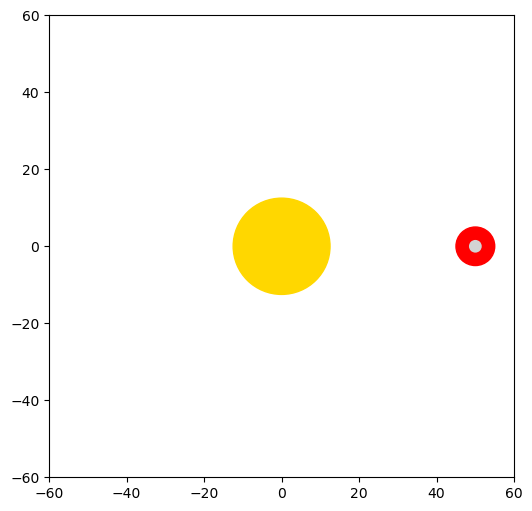

In [4]:
axon_file = dir_res + "myelinated_axon.json"

ax_l = 10000 # um
ax_d=10
ax_y=50
ax_z=0
axon_1 = nrv.myelinated(L=ax_l, d=ax_d, y=ax_y, z=ax_z)


LIFE_stim0 = nrv.FEM_stimulation()
LIFE_stim0.reshape_nerve(Length=ax_l)
life_d = 25 # um
life_length = 1000 # um
life_x_0_offset = life_length/2
life_y_c_0 = 0
life_z_c_0 = 0
elec_0 = nrv.LIFE_electrode("LIFE", life_d, life_length, life_x_0_offset, life_y_c_0, life_z_c_0)

dummy_stim = nrv.stimulus()
dummy_stim.pulse(0, 0.1, 1)
LIFE_stim0.add_electrode(elec_0, dummy_stim)

axon_1.attach_extracellular_stimulation(LIFE_stim0)
axon_1.get_electrodes_footprints_on_axon()
_ = axon_1.save(save=True, fname=axon_file, extracel_context=True)

fig, ax = plt.subplots(1, 1, figsize=(6,6))
axon_1.plot(ax)
ax.set_xlim((-1.2*ax_y, 1.2*ax_y))
ax.set_ylim((-1.2*ax_y, 1.2*ax_y))

del axon_1

Once this static context has been saved in the cost function it should be linked with the `cost_function`.

For that purpose, we can use the method `set_static_context` as bellow. 

Note that additional keys arguments can be added to precise simulation parameter. 
Here we impose a simulation time of $5ms$ and a time step of $5\mu s$. These arguments will be added when the `simulate` method will be called so all the parameters of a standard simulation can be as in previous example

In [ ]:
static_context = axon_file
t_sim = 5
dt = 0.005
kwarg_sim = {
    "dt":dt,
    "t_sim":t_sim,
}

my_cost0.set_static_context(axon_file, **kwarg_sim)

#### Context modifier

The next step is to define how to interpret the tuning parameters to modify the static context. In our problem, we want to modify the LIFE-electrode's stimulus shape and evaluate its impact on the fiber. There are countless ways to define a waveform from a set of points, so let's consider a very simple method:

  $-$ The stimulus is a cathodic conventional square pulse. In this scenario, both the pulse duration $T_{sq}$ and pulse amplitude $I_{sq}$ can be optimized, resulting in a two-dimensional optimization problem. The tuning parameters input vector $\mathcal{X}_{sq}$ of the optimization problem is thus defined as follows:
$$
\mathcal{X}_{sq} = \begin{pmatrix} I_{sq} & T_{sq} \end{pmatrix} \;
$$

#### **Implementation:**

In NRV, the modification of the static context can either be done with a callable class or a function. Some `context_modifier` classes have already been implemented in NRV.

The [biphasic_stimulus_CM](../usersguide/optimization.rst#context-modifier) is appropriate for our problem. Such `context_modifier`([simulable](../usersguide/simulables.rst)) add a biphasic pulse to a given electrode of a `nrv_simulable` object. 
To fit with our problem, we set the following arguments:
 - `start=1`: the cathodic pulse to start at $1ms$.
 - `s_cathod="0"` the cathodic pulse amplitude is defined by the first value of the input vector $\mathcal{X}_{sq}$.
 - `T_cathod="1"` the cathodic pulse duration is defined by the second value of the input vector $\mathcal{X}_{sq}$.
 - `s_anod=0` anodic pulse amplitude is 0 (we consider a monophasic pulse).


.. note::
    Arguments of `biphasic_stimulus_CM` are similar to those of [stimulus.biphasic_pulse](../_nrv/utils/stimulus/nrv.utils.stimulus.biphasic_pulse.rst). User can either set the argument to a specific value or specify that it should be defined by a tuning parameters input vector. In the second case the argument should be a `str` of the index of the argument in the vector.



In [ ]:
t_start = 1
I_max_abs = 100

cm_0 = nrv.biphasic_stimulus_CM(start=t_start, s_cathod="0", t_cathod="1", s_anod=0)
my_cost0.set_context_modifier(cm_0)

The following lines illustrate the stimuli generated by the `cm_0` for various input parameters.

As expected:
 - The first dimension sets the pulse's negative amplitude.
 - The second sets the pulse duration.

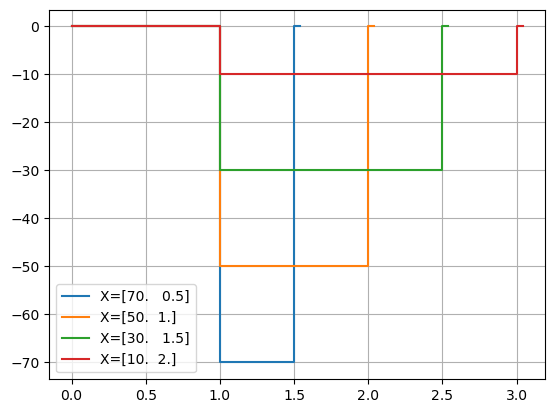

In [7]:
test_points = np.array([[70, 0.5], [50, 1], [30, 1.5], [10, 2]])

fig, ax = plt.subplots()
ax.grid()
for X in test_points:
    axon_x = cm_0(X, static_context)
    stim = axon_x.extra_stim.stimuli[0]
    stim.plot(ax, label=f"X={X}")
    ax.legend()
    del axon_x

#### Cost Evaluation

In our problem, we want at the same time to minimize the energy of the stimulus and maximize the number of fibre recruited. Therefore, we can evaluate the *cost* of a stimulus on the context using the following equation:
$$
    Cost = \alpha_e\sum_{t_k}{i_{stim}^2(t_k)}+\alpha_r(N_{axon}-N_{recruited})
$$

With:
 - $t_k$ as the discrete time step of the simulation.
 - $N_{axon}$ as the number of axon simulated, 1 in this first problem.
 - $N_{recruited}$ as the number of fibre triggered by the stimulation.
 - $\alpha_e$ and $\alpha_r$ as two weighting coefficients.


**Implementation:**

In NRV, the computation of this cost from simulation results is handled by a function or a callable class instance called `cost_evaluation`. As for `context_modifier`, several `cost_evaluation` classes are already implemented in the NRV package. These classes can be combined with algebraic operations to easily generate more complex cases.

Here, the cost evaluation is generated using two classes implemented in NRV:
 1. `recrutement_count_CE`: computes the number of triggered fibres.

 2. `stim_energy_CE`: computes a value proportional to the stimulus energy.


.. note::
    The second term of the equation ($\alpha_r(N_{axon} - N_{recruited})$) essentially represents a function that is 1 if the fibre is triggered and 0 otherwise. This seemingly complicated notation allows us to use the same equation to evaluate a stimulus in contexts involving a larger number of axons.

.. note::
    With a good knowledge of the simulation results, it is possible to implement custom `cost_evaluation`, similar to `context_modifier`.
  It should be a function or a callable class taking a `sim_results` object and any additional `kwargs` parameters, returning a corresponding cost (`float`).



In [ ]:
costR = nrv.recrutement_count_CE(reverse=True)
costC = nrv.stim_energy_CE()

cost_evaluation = costR + 0.01 * costC
my_cost0.set_cost_evaluation(cost_evaluation)

## Optimization problem

At this point, the cost function that should be minimized is fully defined. We can now proceed to define the entire optimization process by selecting the appropriate optimizer.

The cost function defined for this problem is not continuous due to the second term of the cost evaluation equation ($\alpha_r(N_{axon} - N_{recruited})$). Therefore, a meta-heuristic approach is more suitable for our needs.

We can thus instantiate a [PSO_optimizer](../_nrv/optim/nrv.optim.PSO_optimizer.rst) object adapted to our problem as bellow. The parameters relative to the optimization are added
at the instantiation. Here:

 - `maxiter`: sets the number of iterations of the optimization.
 - `n_particles`: set the number of particle of the swarm.
 - `opt_type`: sets the neighbour topology as star (when "global") or ring (when "local").
 - `options`: sets the `Pyswarms`'s PSO option.
 - `bh_strategy`: sets the out-of-bounds handling strategy.

See [Pyswarms](https://pyswarms.readthedocs.io/en/latest/) documentation for more information


In [ ]:
pso_kwargs = {
    "maxiter" : 50,
    "n_particles" : 20,
    "opt_type" : "local",
    "options": {'c1': 0.6, 'c2': 0.6, 'w': 0.8, 'k': 3, 'p': 1},
    "bh_strategy": "reflective",
}
pso_opt = nrv.PSO_optimizer(**pso_kwargs)

Once both the `cost_function` and the `optimizer` are defined the optimization problem can be simply as bellow

In [ ]:
# Problem definition
my_prob = nrv.Problem()
my_prob.costfunction = my_cost0
my_prob.optimizer = pso_opt


By calling this optimizer we can the run the optimization. Additional parameters can be set at this time using key arguments. Here, we use this option to set the PSO parameters relative to this problem:

 - `dimensions`: dimension of the input vector
 - `bounds`: boundaries of each dimension of the input vector
 - `comment`: optional `str` comment which will be added to the results dictionary

An [optim_results](../_nrv/optim/optim_utils/nrv.optim.optim_utils.optim_results.rst) instance will be returned from the optimization containing all results and parameters of the optimization.

.. note::
    The keys to used to parametrize the optimizer are the same as for instantiating the [PSO_optimizer](../_nrv/optim/nrv.optim.PSO_optimizer.rst)

.. note::
    As `optim_results` class inherit from `nrv_result`, all results can either be access as `dictionary` keys or as class attributes and post-processing built-in method can be used



In [ ]:
t_end = 0.5
duration_bound = (0.01, t_end)
bounds0 = (
    (0, I_max_abs),
    duration_bound
)
pso_kwargs_pb_0 = {
    "dimensions" : 2,
    "bounds" : bounds0,
    "comment":"pulse"}

res0 = my_prob(**pso_kwargs_pb_0)

Hurray! The first optimization is now complete.

We can check the best input vector and the best final cost stored in `res0["x"]` and `res0["best_cost"]` respectively.

In [12]:
print("best input vector:", res0["x"], "\nbest cost:", res0["best_cost"])

best input vector: [3.99748583236465, 0.18451328349588564] 
best cost: 0.029485327795478532


We can explore further the results of the optimization by plotting the best stimulus shape and the cost history.


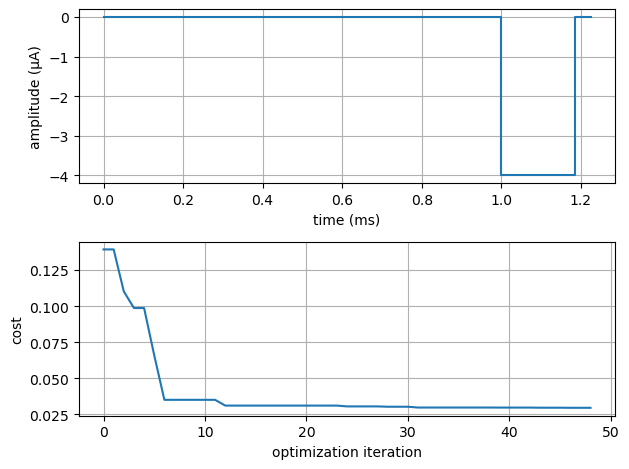

In [13]:
fig_costs, axs_costs = plt.subplots(2, 1)

stim = cm_0(res0.x, static_context).extra_stim.stimuli[0]
stim.plot(axs_costs[0], label="rectangle pulse")
axs_costs[0].set_xlabel("best stimulus shape")
axs_costs[0].set_xlabel("time (ms)")
axs_costs[0].set_ylabel("amplitude (µA)")
axs_costs[0].grid()

res0.plot_cost_history(axs_costs[1])
axs_costs[1].set_xlabel("optimization iteration")
axs_costs[1].set_ylabel("cost")
axs_costs[1].grid()
fig_costs.tight_layout()


Using the method `compute_best_pos`, the axon with the optimized stimulus can be simulated.

This can be useful to make sure the axon is activated by plotting the rasterized $V_{mem}$ as in [Tutorial 1](./1_intracellular_stimulation.ipynb).

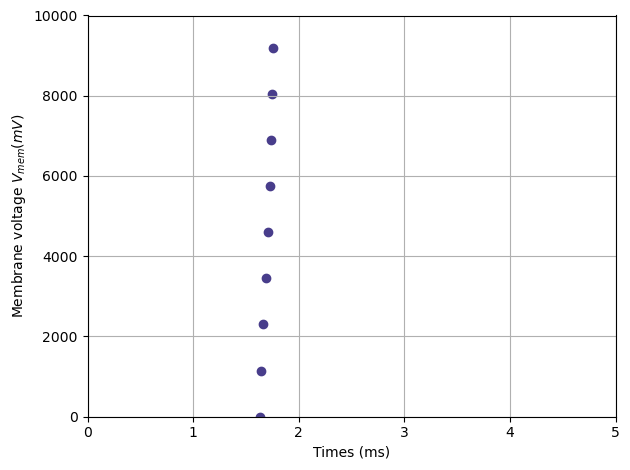

In [14]:
simres = res0.compute_best_pos(my_cost0)
simres.rasterize("V_mem")
plt.figure()
plt.scatter(simres["V_mem_raster_time"], simres["V_mem_raster_x_position"], color='darkslateblue')
plt.xlabel('Times (ms)')
plt.ylabel('Membrane voltage $V_{mem} (mV)$')
plt.xlim(0, t_sim)
plt.ylim(0, simres["L"])
plt.grid()
plt.tight_layout()


## Second optimization spline interpolated stimulus

At this point, we have found a rectangle pulse stimulus shape triggering our fibre with a minimal energy. Let's see if we can find a better cost with a more complex stimulus shape.

In this new problem, we can define the stimulus as a cathodic pulse through interpolated splines over $2$ points which are individually defined in time and amplitude. This second optimization scenario results in a $4$-dimensional problem with the input vector $\mathcal{X}_{s_2}$ defined as:

$$
\mathcal{X}_{s_2} = \begin{pmatrix} I_{s_1} & t_{s_1} & I_{s_2} & t_{s_2}    \end{pmatrix}
$$

With $I_{s_1}$ and $t_{s_1}$ the amplitude and time of the first point and $I_{s_2}$ and $t_{s_2}$ those of the second.


As in the first optimization, the stimulus generation from input vector is handled by the [context_modifier](../usersguide/optimization.rst#context-modifier). So let's define a new one which will fit our purpose. This can be done using another built-in class in NRV: [stimulus_CM](../_nrv/optim/optim_utils/nrv.optim.optim_utils.biphasic_stimulus_CM.rst). 
To fit with our problem the following parameters are set


In [ ]:
kwrgs_interp = {
    "dt": dt,
    "amp_start": 0,
    "amp_stop": 0,
    "intertype": "Spline",
    "bounds": (-I_max_abs, 0),
    "t_sim":t_sim,
    "t_end": t_end,
    "t_shift": t_start,
    }
cm_1 = nrv.stimulus_CM(interpolator=nrv.interpolate_Npts, intrep_kwargs=kwrgs_interp, t_sim=t_sim)

As before, we can plot several stimulus shapes generated from this new `context_modifier`

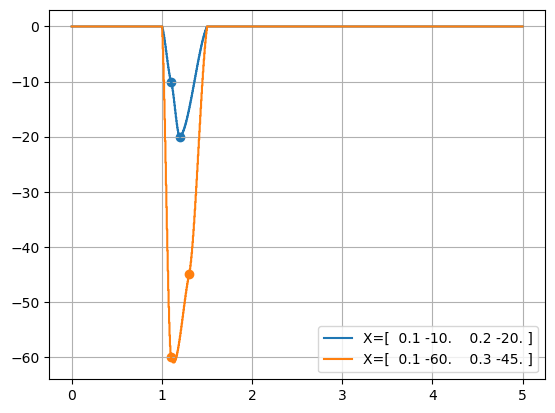

In [16]:
test_points = np.array([[.1, -10, .2, -20], [.1, -60, .3, -45]])

fig, ax = plt.subplots()
ax.grid()
for X in test_points:
    axon_x = cm_1(X, static_context)
    stim = axon_x.extra_stim.stimuli[0]
    stim.plot(ax, label=f"X={X}")
    plt.scatter(t_start+X[::2], X[1::2])
    ax.legend()
    del axon_x

This time all the components of the new `cost_function` are already defined. It can thus be directly defined at the instantiation of the `cost_function` as bellow.

In [ ]:
my_cost_1 = nrv.cost_function(
    static_context=static_context,
    context_modifier=cm_1,
    cost_evaluation=cost_evaluation,
    kwargs_S=kwarg_sim)

We can now update our optimization problem with this second `cost_function`. 

Since the number of dimensions and the bounds of each dimension are different from the first problem, the optimizer parameters must also be updated. This can be done when running the optimization.

In [ ]:
my_prob.costfunction = my_cost_1

I_bound = (-I_max_abs, 0)
t_bound = (0, t_end)
bounds1 = (t_bound, I_bound, t_bound, I_bound)
pso_kwargs_pb_1 = {
    "dimensions" : 4,
    "bounds" : bounds1,
    "comment":"spline",
}

res1 = my_prob(**pso_kwargs_pb_1)

Finally, we can update the figure of the first results with this new optimized stimulus and the cost history to compare the results.


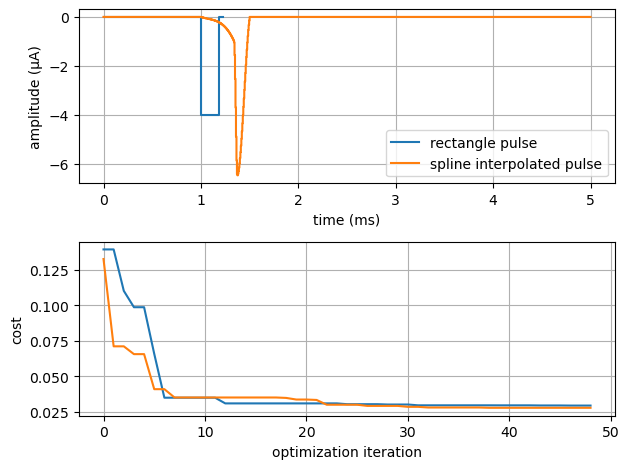

In [19]:
stim = cm_1(res1.x, static_context).extra_stim.stimuli[0]
stim.plot(axs_costs[0], label="spline interpolated pulse")
axs_costs[0].legend()
res1.plot_cost_history(axs_costs[1])
fig_costs

#plt.show()